
# Recommender Systems

In this notebook, we will focus on providing a basic recommendation system by suggesting items that are most similar to a particular item, in this case, movies. Keep in mind, this is not a true robust recommendation system, to describe it more accurately,it just tells you what movies/items are most similar to your movie choice.


### Import Libraries

In [16]:
import numpy as np
import pandas as pd

## Get the Rating Data

In [17]:
column_names = ['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_csv('u.data', sep='\t', names=column_names)

In [18]:
df.head()

,user_id,item_id,rating,timestamp
0,0,50,5,881250949
1,0,172,5,881250949
2,0,133,1,881250949
3,196,242,3,881250949
4,186,302,3,891717742


In [19]:
df.info(), df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100003 entries, 0 to 100002
Data columns (total 4 columns):
user_id      100003 non-null int64
item_id      100003 non-null int64
rating       100003 non-null int64
timestamp    100003 non-null int64
dtypes: int64(4)
memory usage: 3.1 MB


(None, (100003, 4))

## get the movie titles:

In [20]:
movie_titles = pd.read_csv("Movie_Id_Titles")
movie_titles.head()

,item_id,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


## merge them together:

In [22]:
df = pd.merge(df,movie_titles,on='item_id')
df.head()

,user_id,item_id,rating,timestamp,title
0,0,50,5,881250949,Star Wars (1977)
1,290,50,5,880473582,Star Wars (1977)
2,79,50,4,891271545,Star Wars (1977)
3,2,50,5,888552084,Star Wars (1977)
4,8,50,5,879362124,Star Wars (1977)


# EDA

Let's explore the data a bit and get a look at some of the best rated movies.

## Visualization Imports

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
%matplotlib inline

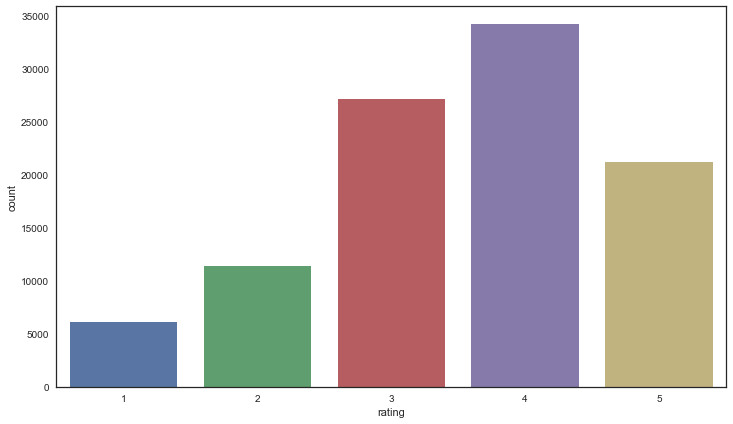

In [41]:
plt.figure(figsize=(12,7))
sns.countplot(x = 'rating', y=None, data = df)

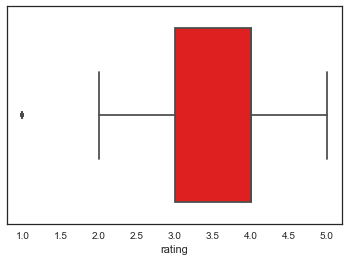

In [40]:
sns.boxplot(y=None, x='rating', color = 'r', order='rating', data=df)

## ratings dataframe with average rating and number of ratings:

In [42]:
df.head()

,user_id,item_id,rating,timestamp,title
0,0,50,5,881250949,Star Wars (1977)
1,290,50,5,880473582,Star Wars (1977)
2,79,50,4,891271545,Star Wars (1977)
3,2,50,5,888552084,Star Wars (1977)
4,8,50,5,879362124,Star Wars (1977)


In [43]:
avg_rat_by_title = df.groupby('title')['rating'].mean().sort_values(ascending = False)

In [44]:
avg_rat_by_title.head()

title
Marlene Dietrich: Shadow and Light (1996)     5.0
Prefontaine (1997)                            5.0
Santa with Muscles (1996)                     5.0
Star Kid (1997)                               5.0
Someone Else's America (1995)                 5.0
Name: rating, dtype: float64

## notice how faily unknown movies are showing very hi Average ratings...let's check their counts

In [60]:
outliers = ['Marlene Dietrich: Shadow and Light (1996)', 'Prefontaine (1997)', 'Santa with Muscles (1996)', \
            'Star Kid (1997)', 'Someone Else\'s America (1995)']
chek_dt = df[df['title'].isin(outliers)]
chek_dt

,user_id,item_id,rating,timestamp,title
93875,87,1189,5,879877951,Prefontaine (1997)
93876,416,1189,5,893213917,Prefontaine (1997)
93877,532,1189,5,892521554,Prefontaine (1997)
96170,279,1500,5,875306613,Santa with Muscles (1996)
96171,781,1500,5,879634096,Santa with Muscles (1996)
99244,489,1293,5,891446623,Star Kid (1997)
99245,519,1293,5,883250148,Star Kid (1997)
99246,146,1293,5,891458080,Star Kid (1997)
99794,437,1599,5,880142614,Someone Else's America (1995)


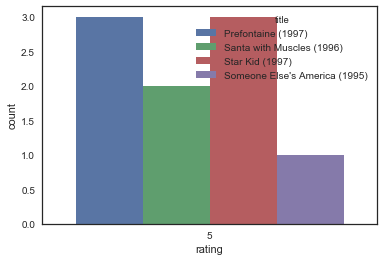

In [57]:
sns.countplot(x= 'rating', y=None, data=chek_dt, hue = 'title')

In [45]:
df.groupby('title')['rating'].count().sort_values(ascending=False).head()

title
Star Wars (1977)             584
Contact (1997)               509
Fargo (1996)                 508
Return of the Jedi (1983)    507
Liar Liar (1997)             485
Name: rating, dtype: int64

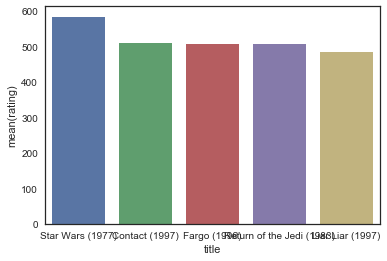

In [70]:
t1= pd.DataFrame(df.groupby('title')['rating'].count().sort_values(ascending=False).head())
t1.reset_index(inplace=True)
t1.columns
sns.barplot(x = 'title', y = 'rating', data = t1)


## Form a dataframe object to store the Average ratings for all titles

In [71]:
ratings = pd.DataFrame(df.groupby('title')['rating'].mean())
ratings.head()

,rating
title,
'Til There Was You (1997),2.333333
1-900 (1994),2.600000
101 Dalmatians (1996),2.908257
12 Angry Men (1957),4.344000
187 (1997),3.024390


## Create the number of ratings column:

In [72]:
ratings['num of ratings'] = pd.DataFrame(df.groupby('title')['rating'].count())
ratings.head()

,rating,num of ratings
title,,
'Til There Was You (1997),2.333333,9
1-900 (1994),2.600000,5
101 Dalmatians (1996),2.908257,109
12 Angry Men (1957),4.344000,125
187 (1997),3.024390,41


## Check distributions for number of ratings for all titles and distribution for the mean ratings of all titles

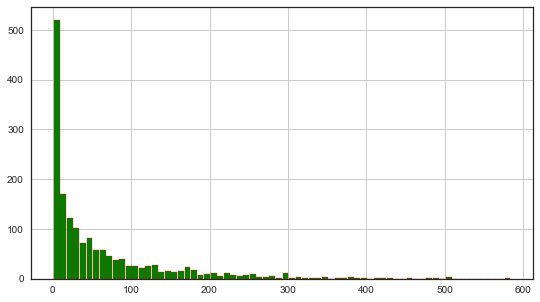

In [83]:
plt.figure(figsize=(9,5))
ratings['num of ratings'].hist(bins=70, rwidth=0.9, color = 'g', edgecolor = 'r')

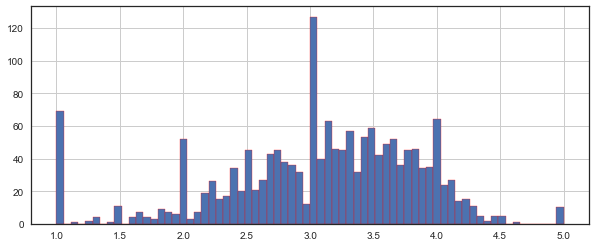

In [86]:
plt.figure(figsize=(10,4))
ratings['rating'].hist(bins=70, edgecolor = 'r')

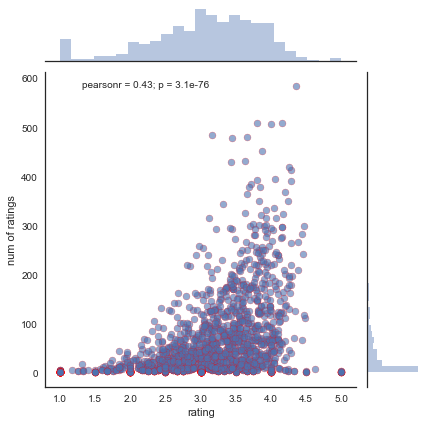

In [90]:
sns.jointplot(x='rating',y='num of ratings',data=ratings,alpha=0.6, edgecolor = 'r')

## Create a simple recommendation system:

### Recommending Similar Movies

#### create a matrix that has the user ids on rows/index and the movie title on y axis/columns. 
Each cell will then consist of the rating the user gave to that movie. Note there will be a lot of NaN values, because most people have not seen most of the movies.

In [91]:
df.head()

,user_id,item_id,rating,timestamp,title
0,0,50,5,881250949,Star Wars (1977)
1,290,50,5,880473582,Star Wars (1977)
2,79,50,4,891271545,Star Wars (1977)
3,2,50,5,888552084,Star Wars (1977)
4,8,50,5,879362124,Star Wars (1977)


In [94]:
moviemat = df.pivot_table(index='user_id',columns='title',values='rating')
moviemat.head()

title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",...,Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,Á köldum klaka (Cold Fever) (1994)
user_id,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,2.0,5.0,NaN,NaN,3.0,4.0,NaN,NaN,...,NaN,NaN,NaN,5.0,3.0,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [95]:
type(moviemat)

pandas.core.frame.DataFrame

### Let's find the most rated movies:
> Use the complete rating trend (by all users) from these popular titles to run similarities/correlation with complete rating trends from rest of the movies in the dataframe to draw similarities b/w titles
>> So, if 2 movies have similar rating trends by same users, then they must be similar!!!!!!!!!

In [96]:
ratings.sort_values('num of ratings',ascending=False).head(10)

,rating,num of ratings
title,,
Star Wars (1977),4.359589,584
Contact (1997),3.803536,509
Fargo (1996),4.155512,508
Return of the Jedi (1983),4.007890,507
Liar Liar (1997),3.156701,485
"English Patient, The (1996)",3.656965,481
Scream (1996),3.441423,478
Toy Story (1995),3.878319,452
Air Force One (1997),3.631090,431


### Let's choose two movies: starwars, a sci-fi movie. And Liar Liar, a comedy.

In [18]:
ratings.head()

,rating,num of ratings
title,,
'Til There Was You (1997),2.333333,9
1-900 (1994),2.600000,5
101 Dalmatians (1996),2.908257,109
12 Angry Men (1957),4.344000,125
187 (1997),3.024390,41


## grab the user ratings for those two movies: (the complete trends, not the mean ratings)

In [99]:
starwars_user_ratings = moviemat['Star Wars (1977)']
liarliar_user_ratings = moviemat['Liar Liar (1997)']
starwars_user_ratings.head(), len(starwars_user_ratings), len(moviemat)

(user_id
 0    5.0
 1    5.0
 2    5.0
 3    NaN
 4    5.0
 Name: Star Wars (1977), dtype: float64, 944, 944)

### use corrwith() method to get correlations between two pandas series:
> DataFrame.corrwith(Series)

In [100]:
similar_to_starwars = moviemat.corrwith(starwars_user_ratings)
similar_to_liarliar = moviemat.corrwith(liarliar_user_ratings)

/Users/admin/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:2995: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/admin/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:2929: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)


Let's clean this by removing NaN values and using a DataFrame instead of a series:

In [101]:
similar_to_starwars.head()

title
'Til There Was You (1997)    0.872872
1-900 (1994)                -0.645497
101 Dalmatians (1996)        0.211132
12 Angry Men (1957)          0.184289
187 (1997)                   0.027398
dtype: float64

In [102]:
corr_starwars = pd.DataFrame(similar_to_starwars,columns=['Correlation'])
corr_starwars.dropna(inplace=True)
corr_starwars.head()

,Correlation
title,
'Til There Was You (1997),0.872872
1-900 (1994),-0.645497
101 Dalmatians (1996),0.211132
12 Angry Men (1957),0.184289
187 (1997),0.027398


### Now if we sort the dataframe by correlation, we should get the most similar movies, however note that we get some results that don't really make sense. 
> This is because there are a lot of movies only watched once by users who also watched star wars

In [103]:
corr_starwars.sort_values('Correlation',ascending=False).head(10)

,Correlation
title,
Hollow Reed (1996),1.0
Stripes (1981),1.0
"Beans of Egypt, Maine, The (1994)",1.0
Safe Passage (1994),1.0
"Old Lady Who Walked in the Sea, The (Vieille qui marchait dans la mer, La) (1991)",1.0
"Outlaw, The (1943)",1.0
"Line King: Al Hirschfeld, The (1996)",1.0
Hurricane Streets (1998),1.0
"Good Man in Africa, A (1994)",1.0


### Let's fix this by filtering out movies that have less than 100 reviews (this value was chosen based off the histogram from earlier).

In [104]:
corr_starwars = corr_starwars.join(ratings['num of ratings'])   ### by default its a left join
corr_starwars.head()

,Correlation,num of ratings
title,,
'Til There Was You (1997),0.872872,9
1-900 (1994),-0.645497,5
101 Dalmatians (1996),0.211132,109
12 Angry Men (1957),0.184289,125
187 (1997),0.027398,41


### Now filter the table to rows with "num of ratings" > 100 and sort the values by 'Correlation' and notice how the titles make a lot more sense:

In [107]:
corr_starwars[corr_starwars['num of ratings']>100].sort_values('Correlation',ascending=False).head()

,Correlation,num of ratings
title,,
Star Wars (1977),1.000000,584
"Empire Strikes Back, The (1980)",0.748353,368
Return of the Jedi (1983),0.672556,507
Raiders of the Lost Ark (1981),0.536117,420
Austin Powers: International Man of Mystery (1997),0.377433,130


### Now the same for the comedy Liar Liar:

In [108]:
corr_liarliar = pd.DataFrame(similar_to_liarliar,columns=['Correlation'])
corr_liarliar.dropna(inplace=True)
corr_liarliar = corr_liarliar.join(ratings['num of ratings'])
corr_liarliar[corr_liarliar['num of ratings']>100].sort_values('Correlation',ascending=False).head()

,Correlation,num of ratings
title,,
Liar Liar (1997),1.000000,485
Batman Forever (1995),0.516968,114
"Mask, The (1994)",0.484650,129
Down Periscope (1996),0.472681,101
Con Air (1997),0.469828,137


---